# Contents:

1. [Description of Baum Welch Algorithm](#1)
- [Implementation of Baum Welch](#2) ([Kalman Filter](#2a), [Kalman Smoother](#2b), [EM](#2c))
- [Visualise EM on Generated Data](#3)
- [Switching State-Space Model - Generate Data from Multiple Chains](#4)
- [Derive Switch Points from MLE](#5)
- [Testing Mean Field SSM on Generated Data](#6)
- [Testing Mean Field SSM on Connected Worlds Data](#7)

In [2494]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import copy

import pymc3 as pm
import scipy as sp

import pydot as pydot
from IPython.display import Image

<a id=1></a>
# Direct Implementation of Expectation Maximisation and Baum Welch on single HMM

### Baum Welch Algorithm for MLE on HMM

A time-series data is generated as a response vector $\bar{\mathbf{y}}$ that contains the water levels for each biome at any given time. The total water in the system is fixed at a constant $L$ and the system has feedback loops dictating where the water can be routed to. Possible examples of feedback loops include:

- A user may direct a lot of water to a specific biome and not leave enough water for other biomes.
- Planting many plants in one biome may result in a faster consumption of water from this biome (requiring more water) but also a faster replenshing of water to the water system through evaporation.

The response vector is from an auto-regressive system that contains variables that are dependent upon one another and are dependent one their histories. An initial and general implementation can model this system as a markov chain where the water levels in the biomes are noisy observations from a state vector that tracks the true water level. $\mathbf{X_t}$ denotes the water in each biome at time step $t$ (i.e. the state of the system at time $t$). $\bar{\mathbf{y_t}}$ denotes the observed water levels at time $t$. 

We assume the first order Markov property: the system state at time $t$ depends only on the system state at time $t-1$ plus system noise. Moreover, the output response at time $t$ depends on the system state at time $t$ plus some observation noise. 

Note that for this discussion I have followed the notation and derivation given by Shumway and Stoffer *[Schlittgen, R., 2008. Robert H. Shumway and David S. Stoffer: Time series analysis and its applications with R examples, 2nd edn. AStA Advances in Statistical Analysis, 92(2), pp.233–234.]*

We have the following state representation for the system:

$$
\mathbf{X_t} = \Phi\mathbf{X_{t-1}} + w_t \\
\mathbf{y_t} = A\mathbf{X_t} + v_t
$$

In the case of Connected Worlds, the system noise is capturing the intuition that the users are following a plan but the specific actions are an imperfect attempt at following the plan. Moreover, the system itself is not entirely controllable in that the water has a 'spraying' nature and thus a perfect action may still result in an imperfect response.

Note that in the general case, we may choose to extend this system to the following representation:
$$
\mathbf{X_t} = \Phi\mathbf{X_{t-1}} + \Upsilon u_t + w_t \\
\bar{\mathbf{y_t}} = A\mathbf{X_t} + \Gamma u_t + v_t
$$

The intuition is that we have decomposed the state and observation transitsions into further representations that depends on the user actions. For now we assume that $A = \mathcal{I}$ (i.e. the states are directly observed in the simulation without any observation noise). Moreover, we assume that the state transitsion matrix $\Phi$ is constant for a specific plan. Lastly, for an initial implementation, the state transitsion noise $w_t$ is a normal random variable wiht mean 0 and variance-covariance matrix $Q$. For convenience, I have included the observation noise $v_t \sim \mathcal{N}(0, \mathbf{R})$, with variance-covariance matrix $\mathbf{R}$ so as not to repeat calculations when we choose to include this variable. For the initial implementation, we set $\mathbf{R} = \mathbf{0}$. 

Different to the trivial maximum likelihood approach that is found [here](https://github.com/NickHoernle/Essil/blob/master/baseline_model/switching-state-space-model.ipynb), we follow the Baum-Welch expectation maximisation approach that guarantees that the log-likelihood of the data is always increasing, under the expectation of the unobserved transitions matrix $\Phi$.

<hr />
<hr />

We define the first state as $\mathbf{X_t} \sim \mathcal{N}(\mu_0, \Sigma_0)$. Then, given the parameters in $\Phi$ we are able to calculate the Complete Data Likelihood from $\{ \mathbf{X_{0:n}}, \mathbf{y_{1:n}} \}$:

$$
p_\Theta (\mathbf{X_{0:n}}, \mathbf{y_{1:n}}) = p_{\mu_0, \Sigma_0}(\mathbf{X_0}) \prod\limits_{t=1}^{n} p_{\Phi, \mathbf{Q}} ( \mathbf{X_t} \vert \mathbf{X_{t-1}} )  p_{R} (  \mathbf{y_t} \vert  \mathbf{X_t} )  
$$

Using the Gaussian assumptions that are given above, and ignoring constants, we have the complete data negative log-likelihood:

$$
-2 L_{X,Y}(\Theta) = ln( \vert \Sigma_0 \vert ) + (X_0 - \mu_0)^T\Sigma_0^{-1}(X_0 - \mu_0)
+ n ln(\vert Q \vert ) + \sum\limits_{t=1}^{n} (X_t - \Phi X_{t-1})^T Q^{-1} (X_t - \Phi X_{t-1})
+ n ln(\vert R \vert ) + \sum\limits_{t=1}^{n} (y_t - A X_{t})^T R^{-1} (y_t - A X_{t})
$$

Note that we do not know the parameters $\Theta = \{ Q, R, \Phi, A \}$ and thus we do not have the complete data likelihood as specified above. If we did, finding the MLE would have been trivial. Rather, let's consider the conditional expectation of the likelihood, given a guess of the parameters $\Theta^{(j-1)}$.

$$
\mathcal{Q}( \Theta \vert \Theta^{(j-1)} = E \left\{ -2 L_{X,Y}(\Theta) \vert y_{1:n},\Theta^{(j-1)} \right\}
$$

The conditional expectations can then be derived as the Kalman Smoothers:

$$
\mathcal{Q}( \Theta \vert \Theta^{(j-1)} ) =  \ln( \vert \Sigma_0 \vert ) + tr \left \{ \Sigma_0^{-1} [P_0^n + (X_0^n - \mu_0)(X_0^n - \mu_0)^T \right \} 
+ n ln(\vert Q \vert ) + tr \left \{ Q^{-1} [S_{11} - S_{10} \Phi^T - \Phi S_{10}^T + \Phi S_{00} \Phi^T \right \} 
+ n ln(\vert R \vert ) + tr \left \{ R^{-1} \sum\limits_{t=1}^{n} [(y_t - AX_t^n)(y_t - AX_t^n)^T + A P_t^n A^T]  \right \}
$$

Note that it is important to see that these smoothers are calculated under the current value of the parameters $\Theta^{(j-1)}$. The overall procedure can be regarded as simply alternating between the Kalman filtering and smoothing recursions and the multivariate normal maximum likelihood estimators.

The Markov Chain that is described above for:

$$
\mathbf{X_t} = \Phi\mathbf{X_{t-1}} + w_t \\
\mathbf{y_t} = A\mathbf{X_t} + v_t
$$

can be represented by the graphical description below.

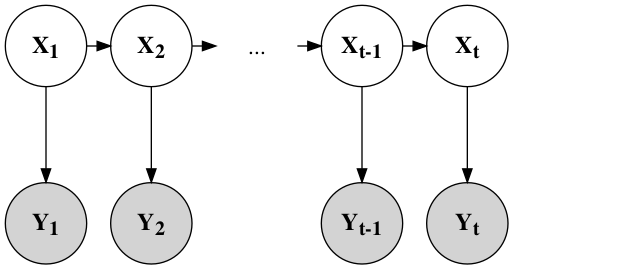

In [2566]:
Image('basic_ssm.png')

<a id=2></a>
# Implementation of Baum-Welsh

<a id=2a></a>
## Kalman Filter

In [2425]:
def BuildPhi(theta):
    
    Phi = np.eye(N) + np.concatenate([[[j] for j in theta[0:5]] for i in range(N)], axis=1)
    Phi = Phi/np.sum(Phi, axis=0) 
    
    return Phi

def KalmanFilterUpdate(y_t, x_tmin1_tmin1, P_tmin1_tmin1, Phi, Q, R):

    # ii - we need the forward Kalman Filter
    x_t_tmin1 = Phi.dot(x_tmin1_tmin1)
    P_t_tmin1 = Phi.dot(P_tmin1_tmin1).dot(Phi.T)
    P_t_tmin1[0:N, 0:N] += Q
    
    sigma_t = A.dot(P_t_tmin1).dot(A.T) + R
    sigma_t_inv = np.linalg.pinv(sigma_t)
    
    K_t = P_t_tmin1.dot(A.T).dot(sigma_t_inv)
    
    epsilon_t = y_t - (A.dot(x_t_tmin1)) # checked

    x_t_t = x_t_tmin1 + K_t.dot(epsilon_t)
    P_t_t = (np.eye(N) - K_t.dot(A)).dot(P_t_tmin1)
    
    return {
        "x_t_t" : x_t_t,
        "x_tmin1_t" : x_t_tmin1,
        "P_t_t" : P_t_t,
        "P_tmin_t" : P_t_tmin1,
        "Sig_t_inv" : sigma_t_inv,
        "Sig_t" : sigma_t,
        "Innovation_t" : epsilon_t,
        "K_t": K_t
        }


def ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R, **kwargs):

    x_tmin1_tmin1 = mu0
    P_tmin1_tmin1 = Sig0
    
    Xs = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    Ps = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))
    X_smin1_s = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    P_smin1_s = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))

    
    Xs[0] = x_tmin1_tmin1
    Ps[0] = P_tmin1_tmin1
    X_smin1_s[0] = x_tmin1_tmin1
    P_smin1_s[0] = P_tmin1_tmin1
    
    incomplete_likelihood = 0
    
    for i, yt in enumerate(ys):
        
        param_update = KalmanFilterUpdate(
                y_t = yt,
                x_tmin1_tmin1 = Xs[i],
                P_tmin1_tmin1 = Ps[i],
                Phi = Phi,
                Q = Q,
                R = R
            )
        x_t_t = param_update['x_t_t']
        P_t_t = param_update['P_t_t']
        
        x_tmin1_t = param_update['x_tmin1_t']
        P_tmin1_t = param_update['P_tmin_t']
        
        Xs[i+1] = x_t_t
        Ps[i+1] = P_t_t
        X_smin1_s[i+1] = x_tmin1_t
        P_smin1_s[i+1] = P_tmin1_t
        
        this_likelihood = 0.5 * np.log(np.linalg.det(param_update['Sig_t']))
        this_likelihood += 0.5 * np.log(param_update['Innovation_t'].T.dot(param_update['Sig_t_inv']).dot(param_update['Innovation_t']))
        
        incomplete_likelihood += this_likelihood
            
    return {
        "Xs": Xs,
        "Ps": Ps,
        "X_smin1_s":X_smin1_s,
        "P_smin1_s":P_smin1_s,
        "Kn": param_update['K_t'],
        "incomplete_likelihood": incomplete_likelihood
    }    

In [2426]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = 25*np.eye(N) + np.concatenate([[[.5],[.05],[.1],[.2],[.05]] for i in range(N)], axis=1)
Phi = Phi/np.sum(Phi, axis=0) 

for i in timesteps:
    
    delta = Phi + np.random.normal([0,0,0,0,0], 0.004*np.ones(N))
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)
water_sim = water
Phi_real = Phi

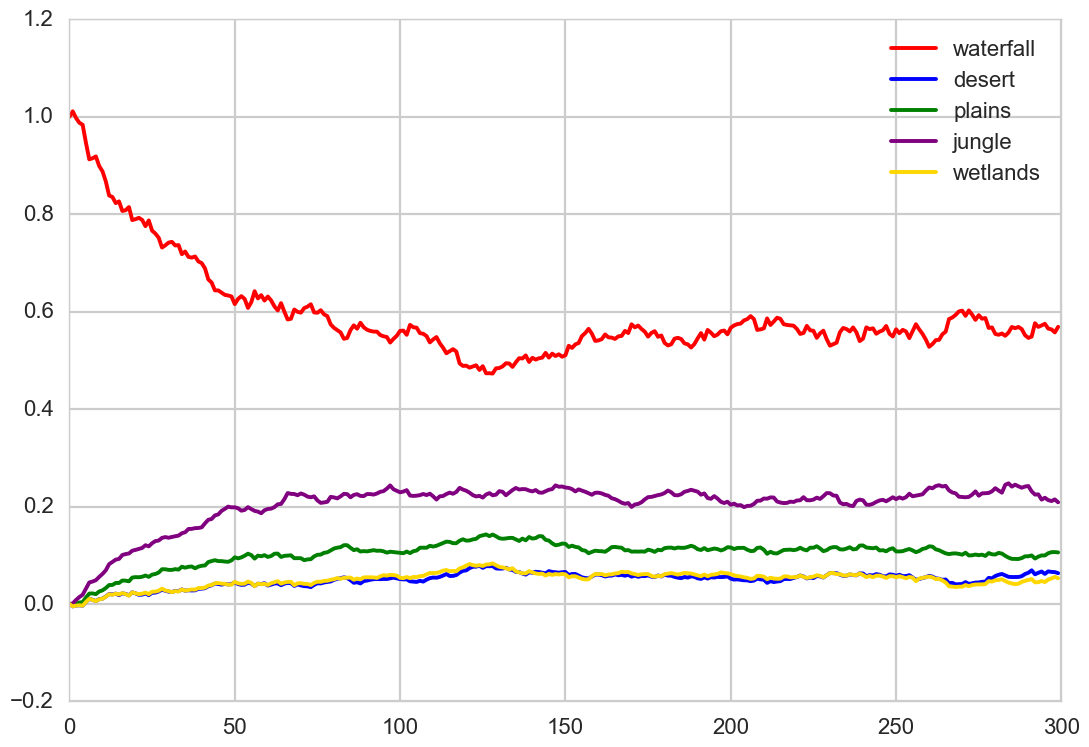

In [2427]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], label=labels[i], c=c[i])

plt.legend(loc='best')
plt.show()

In [2428]:
# test the filter:
ys = water_sim
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(len(mu0)) * 1e-2
Q = np.eye(len(mu0)) * 1e-2
R = np.eye(len(mu0)) * 1e-5

fwd_params = ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R, test="hello")
fwd_params.keys()

dict_keys(['Ps', 'Kn', 'X_smin1_s', 'incomplete_likelihood', 'Xs', 'P_smin1_s'])

<a id=2b></a>
## Kalman Smoother

In [2429]:
def SmootherUpdate(x_n_t, P_n_t, t, Phi, fwd_params):
    
    x_tmin1_tmin1 = fwd_params['Xs'][t-1]
    x_tmin1_t = fwd_params['X_smin1_s'][t]
    
    P_tmin1_tmin1 = fwd_params['Ps'][t-1]
    P_tmin1_t = fwd_params['P_smin1_s'][t]
    
    J_tmin1 = P_tmin1_tmin1.dot(Phi.T).dot(np.linalg.pinv(P_tmin1_t))
    x_n_tmin1 = x_tmin1_tmin1 + J_tmin1.dot(x_n_t - x_tmin1_t)    
    P_n_tmin1 = P_tmin1_tmin1 + J_tmin1.dot( P_n_t - P_tmin1_t).dot(J_tmin1.T)
    
    return {
        "x_n_tmin1": x_n_tmin1,
        "P_n_tmin1": P_n_tmin1,
        "J_tmin1" : J_tmin1
    }

def KalmanSmoother(fwd_params, Phi):
    
    n = len(fwd_params["Xs"])
            
    x_n_n = fwd_params["Xs"][-1]
    P_n_n = fwd_params["Ps"][-1]
        
    Xn = np.zeros((n, len(x_n_n)))
    Pn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    Jn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    
    Xn[-1] = x_n_n
    Pn[-1] = P_n_n
    
    for t in range(n-1, -1, -1):

        smt_update = SmootherUpdate(x_n_n, P_n_n, t, Phi, fwd_params)
        
        x_n_n = smt_update["x_n_tmin1"]
        P_n_n = smt_update["P_n_tmin1"]
        
        Xn[t] = x_n_n
        Pn[t] = P_n_n
        Jn[t] = smt_update["J_tmin1"]
        
    return {
        "Xn": Xn,
        "Pn": Pn,
        "Jn": Jn
    }

In [2430]:
bkwd_params = KalmanSmoother(fwd_params, Phi)
bkwd_params["Xn"][1], fwd_params['Xs'][1]

(array([  1.00778060e+00,  -9.10458666e-04,  -1.87484701e-03,
         -3.80362368e-03,  -9.10458701e-04]),
 array([  9.99992067e-01,   1.05400877e-06,   2.05314594e-06,
          4.05142028e-06,   1.05400877e-06]))

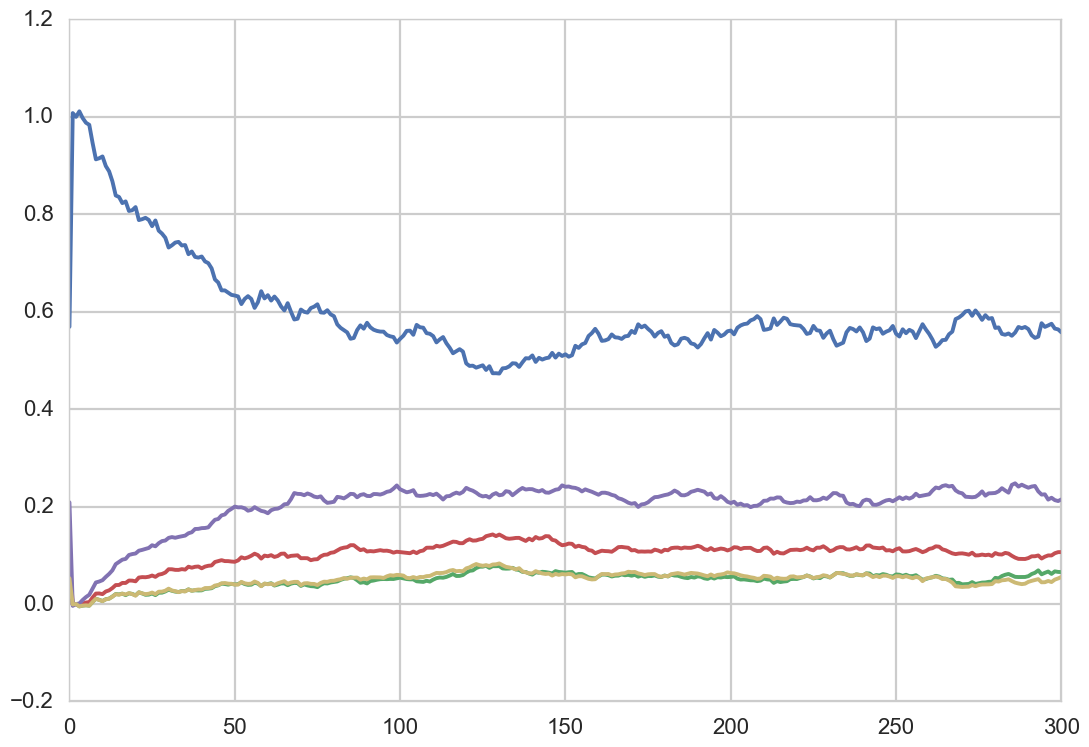

In [2431]:
for i in range(5):
    
    plt.plot(bkwd_params["Xn"][0:,i])

<a id=2c></a>
## Baum-Welsh Update

In [2432]:
def OneLagUpdate(P_n_t_tmin1, t, Ps, Jn, Phi):
    
    P_n_tmin1_tmin2 = Ps[t-1].dot(Jn[t-2].T) + Jn[t-1].dot(P_n_t_tmin1 - Phi.dot(Ps[t-1])).dot(Jn[t-2].T)
        
    return P_n_tmin1_tmin2
        
def OneLagCovarianceSmoother(fwd_params, bkwd_params):
    
    n = len(fwd_params["Xs"])
    K = len(fwd_params["Xs"][0])
    
    Kn = fwd_params['Kn']
    P_n_n_nmin1 = (np.eye(K) - Kn.dot(A)).dot(Phi).dot(bkwd_params["Pn"][-2])
    
    P_one_lag = np.zeros((n, P_n_n_nmin1.shape[0], P_n_n_nmin1.shape[1]))
    P_one_lag[-1] = P_n_n_nmin1
    
    Ps = fwd_params['Ps']
    Jn = bkwd_params['Jn']
    
    for t in range(n-1, 1, -1):
        
        P_n_tmin1_tmin2 = OneLagUpdate(P_n_n_nmin1, t, Ps, Jn, Phi)
        P_one_lag[t] = P_n_tmin1_tmin2
        
    return P_one_lag

def MaximisationUpdate(ys, fwd_params, bkwd_params):
    
    Pn = bkwd_params['Pn']
    Xn = bkwd_params['Xn']
    Pn_one_lag = OneLagCovarianceSmoother(fwd_params, bkwd_params)
    
    n = len(fwd_params['Xs'])
    start = 2
    end = n
    
    S_1_0 = np.zeros_like(fwd_params['Ps'][0])
    S_1_1 = np.zeros_like(fwd_params['Ps'][0])
    S_0_0 = np.zeros_like(fwd_params['Ps'][0])
    
    for (x_n_t, x_n_tmin1, P_n_t, P_n_tmin1, P_n_t_tmin1) in zip(Xn[start+1:end], 
                                                                Xn[start:end-1], 
                                                                Pn[start+1:end],
                                                                Pn[start:end-1],
                                                                Pn_one_lag[start:end-1]):
        
        x_n_t = x_n_t.reshape(-1,1)
        x_n_tmin1 = x_n_tmin1.reshape(-1,1)
        
        S_1_1 += x_n_t.dot(x_n_t.T) + P_n_t
        S_1_0 += x_n_t.dot(x_n_tmin1.T) + P_n_t_tmin1 #TODO this one is wrong
        S_0_0 += x_n_tmin1.dot(x_n_tmin1.T) + P_n_tmin1
    
    S_0_0_inv = np.linalg.pinv(S_0_0)
    
    Phi_j = S_1_0.dot(S_0_0_inv)
    Q_j = 1/(n) * (S_1_1 - S_1_0.dot(S_0_0_inv).dot(S_1_0.T))
    
    for i, row in enumerate(Q_j):
        for j,_ in enumerate(row):
            if i != j:
                Q_j[i,j] = 0
    
    R_j = np.zeros_like(A.dot(A.T))
    for y, X, P in zip(ys[1:], Xn[1:], Pn[1:]):
        
        R_j += (y - A.dot(X)).dot((y - A.dot(X)).T) + A.dot(P).dot(A.T)
        
    R_j /= (n)
    
    eig = np.linalg.eig(Phi_real)[1][:,0]
    eig/np.sum(eig)

    return { "mu0": Xn[1],
             "muEnd": Xn[-1],
             "Sig0": Pn[1], 
             "Phi": Phi_j, 
             "Q": Q_j, 
             "R": R_j,
             "thetas": eig }               
    
def EM_step(ys, params):
    
    mu0 = params['mu0']
    Sig0 = params['Sig0']
    Phi = params['Phi']
    Q = params['Q']
    R = params['R']
    
    # Expectation Step (using Kalman Filter and Smoother)
    fwd_params = ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R)
    bkwd_params = KalmanSmoother(fwd_params, Phi)
    
    # Maximisation Step (using update equation that was derived in [1])
    update_params = MaximisationUpdate(ys, fwd_params, bkwd_params)
    
    return update_params, fwd_params['incomplete_likelihood']

def ExpectationMaximisation(ys, starting_params):
    
    num_iter = 100
    
    params = starting_params
    lklihoods = np.zeros(num_iter)
    
    for _ in range(num_iter):
        
        params_new, likelihood = EM_step(ys, params)
        
        Phi = params_new['Phi']
        
#         BuildPhi(theta)
        
        params['Phi'] = Phi
        params['mu0'] = params_new['mu0']
        params['Sig0'] = params_new['Sig0']
        params['muEnd'] = params_new['muEnd']
        params['Q'] = params_new['Q']
#         params['R'] = params_new['R']
        
        lklihoods[_] = likelihood
        
    return params, lklihoods

In [2433]:
result = MaximisationUpdate(ys, fwd_params, bkwd_params)

<a id=3></a>
# Test EM on Generated Data

In [2434]:
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(5)*1e-1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8

params = { "mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R } 

In [2435]:
result_params, lk = ExpectationMaximisation(ys, params)

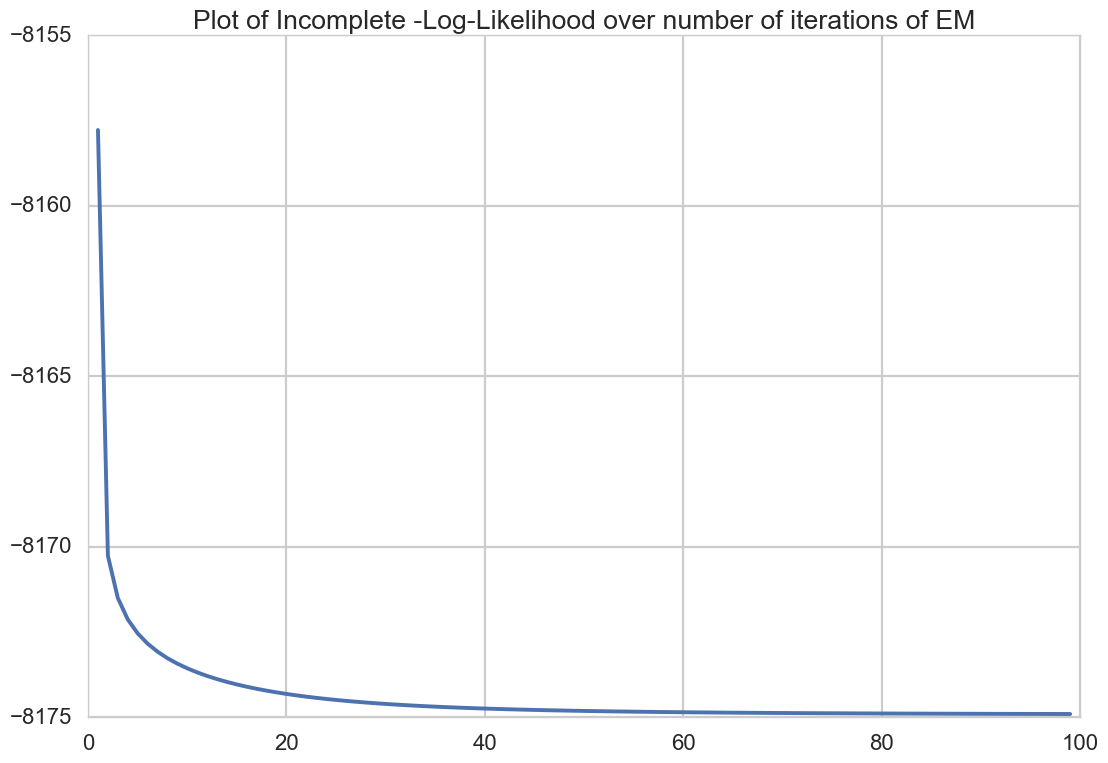

In [2438]:
plt.plot(lk)
plt.title("Plot of Incomplete -Log-Likelihood over number of iterations of EM")
plt.show()

In [2439]:
result_params

{'Phi': array([[ 0.9863842 ,  0.17189522, -0.01710554,  0.01363986, -0.05731276],
        [ 0.00118031,  0.93055625, -0.02039984,  0.0148108 ,  0.04020304],
        [ 0.00387141, -0.04191839,  0.93503025,  0.01280534,  0.08306706],
        [ 0.00737864, -0.01964863,  0.09728877,  0.95045875, -0.05165333],
        [ 0.00118704, -0.04069516,  0.00521726,  0.00821552,  0.98570998]]),
 'Q': array([[  9.25938888e-05,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   7.11371448e-06,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   9.15686762e-06,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.73183800e-05,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   6.94860749e-06]]),
 'R': array([[  1.00000000e-08,   0.00000000e+00,   0.00000000e+

# Look at the largest Eigen Vector of the Learnt Matrix

A note here is that it might not be as useful to use the eigen vectors from the learnt matrix but rather iterate the known starting point of water ($\mu_0$, $\Sigma_0$) through the transition matrix Phi to show the change in water from timestep $t$ to timestep $t+1$. 

In [2441]:
lambda_, eigs = np.linalg.eig(result_params['Phi'])
eig = (eigs[:, np.argmax(lambda_)]/np.sum(eigs[:, np.argmax(lambda_)])).real
eig

array([ 0.55674479,  0.0558872 ,  0.11099123,  0.22144906,  0.05492772])

In [2442]:
lambda_, eigs = np.linalg.eig(Phi_real)
eig = (eigs[:, np.argmax(lambda_)]/np.sum(eigs[:, np.argmax(lambda_)])).real
eig

array([ 0.55555556,  0.05555556,  0.11111111,  0.22222222,  0.05555556])

Notice that these normalised eigen vectors are very similar

In [2443]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = result_params['Phi']
Phi = Phi/np.sum(Phi, axis=0) 

for i in timesteps:
    
    delta = Phi
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)

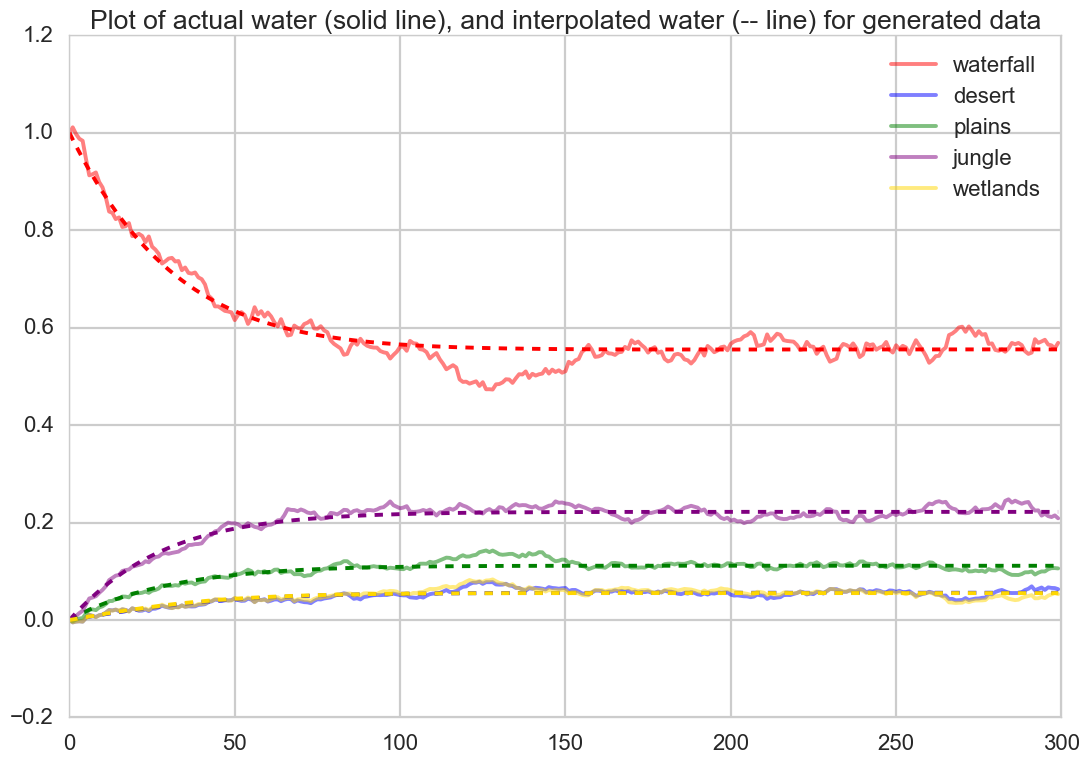

In [2444]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')
    ax.plot(water_sim[:,i], label=labels[i], c=c[i], alpha=0.5)

plt.legend(loc='best')
plt.title("Plot of actual water (solid line), and interpolated water (-- line) for generated data")
plt.show()

<a id=4></a>
# Switching State-Space Model - Consider multiple possible Markov Chains

We now consider the case that we have M distinct Markov chains in the system. Each chain describes the system characteristics for a pariod of time and a switching parameter dictates the change from one causal chain to the next. For example the system starts off under some response that is dictated by chain $m_1$, at time $t_{m_1}$, the sytem dynamics change (due to some change in the users' plan) to rather be driven by the parameters from chain $m_2$ e.t.c. This process can continue for $M$ possible independent Markov chains.

The below graphical model describes this scenario:

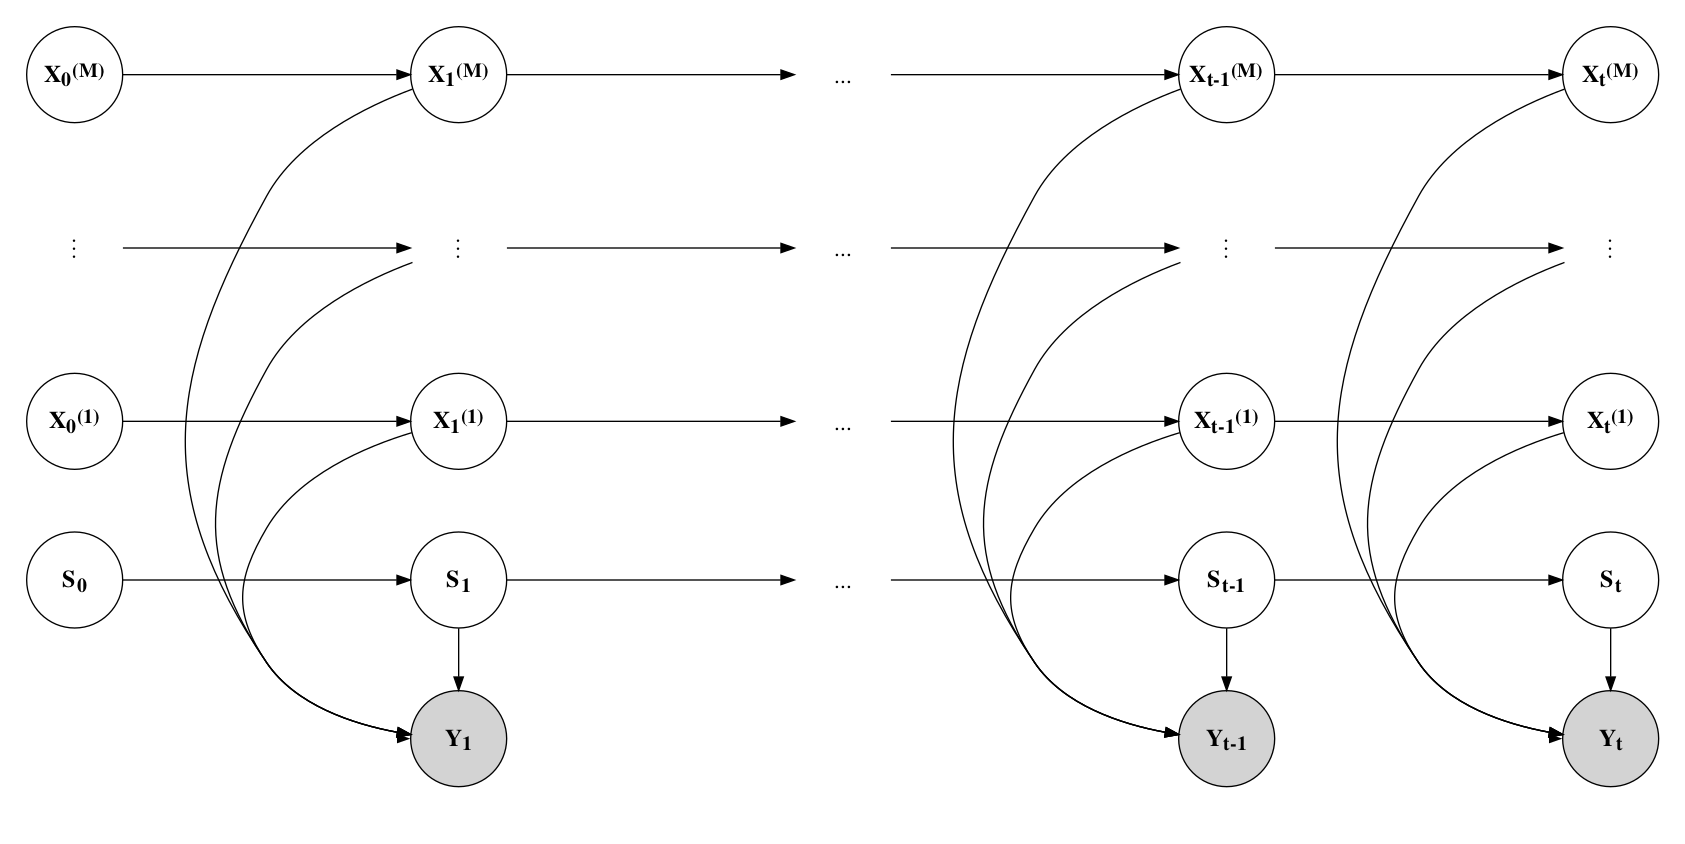

In [2627]:
Image('switching_SSM.png')

In [21]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phis = []
params = []
np.random.seed(8)

for i in range(3):
    param = np.random.dirichlet(np.ones(5))
    
    Phi0 = 25*np.eye(N) + np.concatenate([np.array(param).reshape(-1,1) for i in range(N)], axis=1)
    Phi0 = Phi0/np.sum(Phi0, axis=0)
    
    Phis.append(Phi0)
    params.append(param)
    
j = 0
Phi0 = Phis[j]
times = []

for i in timesteps:
    
    if np.random.binomial(1, 1/90) == 1:
        if j < len(Phis)-1:
            j += 1
            Phi0 = Phis[j]
            times.append(i)
    
    delta = Phi0 + np.random.normal([0,0,0,0,0], 0.004*np.ones(N))
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)
water_sim = water

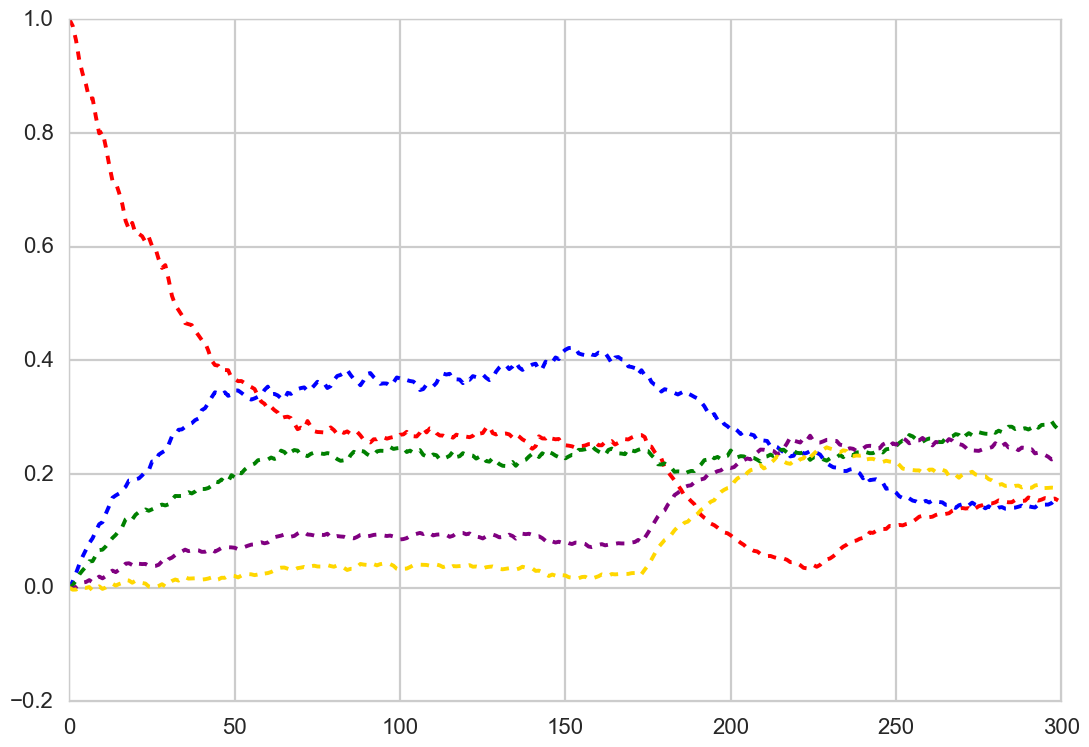

In [22]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')
#     ax.plot(water_sim[:,i], label=labels[i], c=c[i], alpha=0.5)

# plt.legend(loc='best')
plt.show()

In [23]:
ys = water
params

[array([ 0.24085282,  0.40306839,  0.23701786,  0.08819167,  0.03086926]),
 array([ 0.00462352,  0.22703349,  0.20759874,  0.29826213,  0.26248212]),
 array([ 0.15472837,  0.14965678,  0.27316305,  0.23789097,  0.18456084])]

In [24]:
times

[174, 227]

In [25]:
breaks = [0,times[0],times[1],len(ys)-1]
mu0 = np.array([1,0,0,0,0])

Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-1
R = np.eye(5)*0

params0 = { "mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           'A': np.eye(5),
          } 

params1 = copy.deepcopy(params0)
params2 = copy.deepcopy(params0)
params3 = copy.deepcopy(params0)

result_params0, lk0 = ExpectationMaximisation(ys[breaks[0]:breaks[1]], params1)

params2["mu0"] = result_params0['muEnd']
result_params1, lk1 = ExpectationMaximisation(ys[breaks[1]:breaks[2]], params2)

params3["mu0"] = result_params1['muEnd']
result_params2, lk2 = ExpectationMaximisation(ys[breaks[2]:breaks[3]], params3)

In [26]:
lambda_, eigs = np.linalg.eig(result_params0['Phi'])
eig = (eigs[:, np.argmax(lambda_)]/np.sum(eigs[:, np.argmax(lambda_)])).real
eig

array([ 0.25409513,  0.38337772,  0.23902933,  0.09013971,  0.03335812])

In [27]:
lambda_, eigs = np.linalg.eig(result_params1['Phi'])
eig = (eigs[:, np.argmax(lambda_)]/np.sum(eigs[:, np.argmax(lambda_)])).real
eig

array([ 0.00738962,  0.21509723,  0.23927229,  0.27778952,  0.26045134])

In [28]:
lambda_, eigs = np.linalg.eig(result_params2['Phi'])
eig = (eigs[:, np.argmax(lambda_)]/np.sum(eigs[:, np.argmax(lambda_)])).real
eig

array([ 0.15431383,  0.1582783 ,  0.28250157,  0.22599338,  0.17891292])

In [29]:
results = [result_params0, result_params1, result_params2]

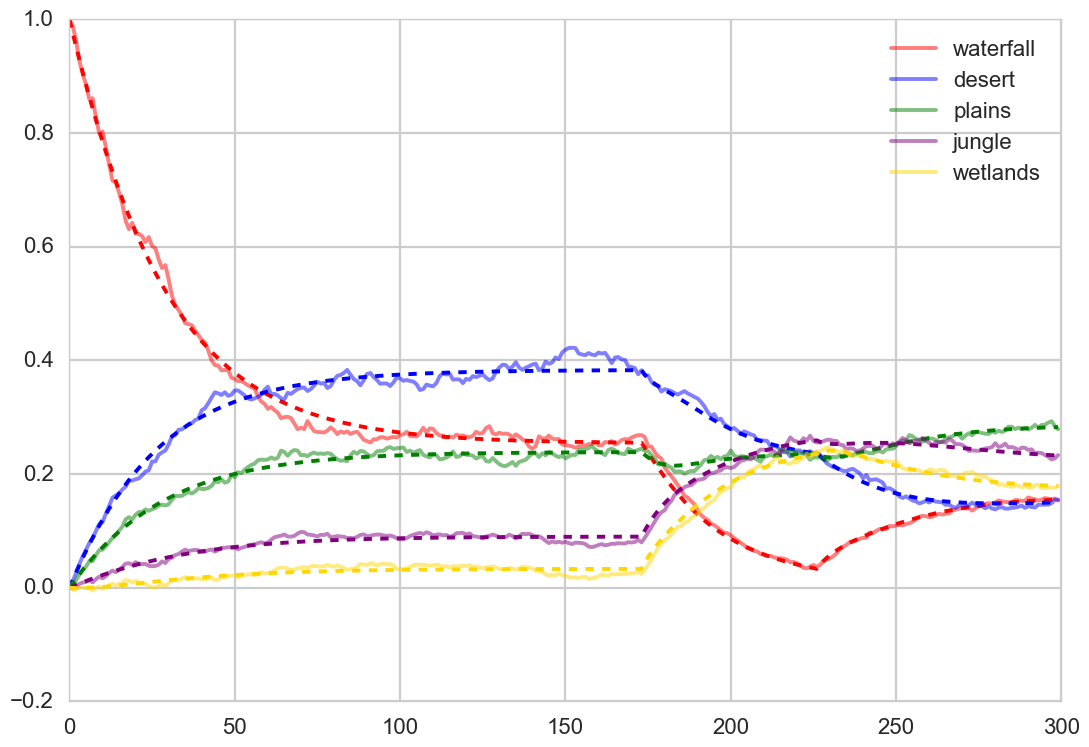

In [30]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = results[0]['Phi']
Phi = Phi/np.sum(Phi, axis=0) 

j = 1
for i in timesteps:
    
    if j <= len(times):
        if i >= times[j-1]:
            
            Phi = results[j]['Phi']
            Phi = Phi/np.sum(Phi, axis=0) 
            j += 1
        
    delta = Phi
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')
    ax.plot(water_sim[:,i], label=labels[i], c=c[i], alpha=0.5)

plt.legend(loc='best')
plt.show()

In [31]:
import scipy as sp
import scipy.stats as stats


In [32]:
stats.norm(loc = 0, scale = 1).pdf(.5)

0.35206532676429952

# Switching State Space Model

In [1114]:
def BuildPhi(theta):
    
    Phi = np.eye(N) + np.concatenate([[[j] for j in theta[0:5]] for i in range(N)], axis=1)
    Phi = Phi/np.sum(Phi, axis=0) 
    
    return Phi

def KalmanFilterUpdate(y_t, x_tmin1_tmin1, P_tmin1_tmin1, Phi, Q, R, **kwargs):
    
    weight = kwargs['weight'] if 'weight' in kwargs else 1

    # ii - we need the forward Kalman Filter
    x_t_tmin1 = Phi.dot(x_tmin1_tmin1)
    P_t_tmin1 = Phi.dot(P_tmin1_tmin1).dot(Phi.T)
    P_t_tmin1[0:N, 0:N] += Q
    
    sigma_t = A.dot(P_t_tmin1).dot(A.T) + R
    sigma_t_inv = np.linalg.pinv(sigma_t)
    
    K_t = P_t_tmin1.dot(A.T).dot(sigma_t_inv)
    
    epsilon_t = (y_t - (A.dot(x_t_tmin1))) * weight

    x_t_t = x_t_tmin1 + K_t.dot(epsilon_t)
    P_t_t = (np.eye(N) - K_t.dot(A)).dot(P_t_tmin1)
    
    return {
        "x_t_t" : x_t_t,
        "x_tmin1_t" : x_t_tmin1,
        "P_t_t" : P_t_t,
        "P_tmin_t" : P_t_tmin1,
        "Sig_t_inv" : sigma_t_inv,
        "Sig_t" : sigma_t,
        "Innovation_t" : epsilon_t,
        "K_t": K_t
        }


def ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R, **kwargs):

    x_tmin1_tmin1 = mu0
    P_tmin1_tmin1 = Sig0
    
    Xs = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    Ps = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))
    X_smin1_s = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    P_smin1_s = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))

    
    Xs[0] = x_tmin1_tmin1
    Ps[0] = P_tmin1_tmin1
    X_smin1_s[0] = x_tmin1_tmin1
    P_smin1_s[0] = P_tmin1_tmin1
    
    incomplete_likelihood = 0
    innovations = np.zeros_like(ys)
    
    for i, yt in enumerate(ys):
        
        if 'weights' in kwargs:
            
            param_update = KalmanFilterUpdate(
                y_t = yt,
                x_tmin1_tmin1 = Xs[i],
                P_tmin1_tmin1 = Ps[i],
                Phi = Phi,
                Q = Q,
                R = R,
                weight = kwargs['weights'][i]
            )
        else:
            param_update = KalmanFilterUpdate(
                y_t = yt,
                x_tmin1_tmin1 = Xs[i],
                P_tmin1_tmin1 = Ps[i],
                Phi = Phi,
                Q = Q,
                R = R
            )
            
        x_t_t = param_update['x_t_t']
        P_t_t = param_update['P_t_t']
        
        x_tmin1_t = param_update['x_tmin1_t']
        P_tmin1_t = param_update['P_tmin_t']
        
        Xs[i+1] = x_t_t
        Ps[i+1] = P_t_t
        X_smin1_s[i+1] = x_tmin1_t
        P_smin1_s[i+1] = P_tmin1_t
        
        this_likelihood = 0.5 * np.log(np.linalg.det(param_update['Sig_t']))
        innov_err = param_update['Innovation_t'].T.dot(param_update['Sig_t_inv']).dot(param_update['Innovation_t'])
        this_likelihood += 0.5 * np.log(innov_err)
        
        incomplete_likelihood += this_likelihood
        
        innovations[i] = param_update['Innovation_t']
            
    return {
        "Xs": Xs,
        "Ps": Ps,
        "X_smin1_s":X_smin1_s,
        "P_smin1_s":P_smin1_s,
        "Kn": param_update['K_t'],
        "incomplete_likelihood": incomplete_likelihood,
        'innovations': innovations
    }   

def SmootherUpdate(x_n_t, P_n_t, t, Phi, fwd_params, **kwargs):
    
    x_tmin1_tmin1 = fwd_params['Xs'][t-1]
    x_tmin1_t = fwd_params['X_smin1_s'][t]
    
    P_tmin1_tmin1 = fwd_params['Ps'][t-1]
    P_tmin1_t = fwd_params['P_smin1_s'][t]
    
    J_tmin1 = P_tmin1_tmin1.dot(Phi.T).dot(np.linalg.pinv(P_tmin1_t))
    
    weight = 1 if 'weights' not in kwargs else kwargs['weights'][t]
    
    x_n_tmin1 = x_tmin1_tmin1 + J_tmin1.dot(x_n_t - x_tmin1_t)
    P_n_tmin1 = P_tmin1_tmin1 + J_tmin1.dot( P_n_t - P_tmin1_t).dot(J_tmin1.T)
    
    return {
        "x_n_tmin1": x_n_tmin1,
        "P_n_tmin1": P_n_tmin1,
        "J_tmin1" : J_tmin1
    }

def KalmanSmoother(fwd_params, Phi, **kwargs):
    
    n = len(fwd_params["Xs"])
            
    x_n_n = fwd_params["Xs"][-1]
    P_n_n = fwd_params["Ps"][-1]
        
    Xn = np.zeros((n, len(x_n_n)))
    Pn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    Jn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    
    Xn[-1] = x_n_n
    Pn[-1] = P_n_n
    
    for t in range(n-1, -1, -1):

        smt_update = SmootherUpdate(x_n_n, P_n_n, t, Phi, fwd_params, **kwargs)
        
        x_n_n = smt_update["x_n_tmin1"]
        P_n_n = smt_update["P_n_tmin1"]
        
        Xn[t] = x_n_n
        Pn[t] = P_n_n
        Jn[t] = smt_update["J_tmin1"]
        
    return {
        "Xn": Xn,
        "Pn": Pn,
        "Jn": Jn
    }

def OneLagUpdate(P_n_t_tmin1, t, Ps, Jn, Phi):
    
    P_n_tmin1_tmin2 = Ps[t-1].dot(Jn[t-2].T) + Jn[t-1].dot(P_n_t_tmin1 - Phi.dot(Ps[t-1])).dot(Jn[t-2].T)
        
    return P_n_tmin1_tmin2
        
def OneLagCovarianceSmoother(fwd_params, bkwd_params):
    
    n = len(fwd_params["Xs"])
    K = len(fwd_params["Xs"][0])
    
    Kn = fwd_params['Kn']
    P_n_n_nmin1 = (np.eye(K) - Kn.dot(A)).dot(Phi).dot(bkwd_params["Pn"][-2])
    
    P_one_lag = np.zeros((n, P_n_n_nmin1.shape[0], P_n_n_nmin1.shape[1]))
    P_one_lag[-1] = P_n_n_nmin1
    
    Ps = fwd_params['Ps']
    Jn = bkwd_params['Jn']
    
    for t in range(n-1, 1, -1):
        
        P_n_tmin1_tmin2 = OneLagUpdate(P_n_n_nmin1, t, Ps, Jn, Phi)
        P_one_lag[t] = P_n_tmin1_tmin2
        
    return P_one_lag

def MaximisationUpdate(ys, fwd_params, bkwd_params, **kwargs):
    
    Pn = bkwd_params['Pn']
    Xn = bkwd_params['Xn']
    Pn_one_lag = OneLagCovarianceSmoother(fwd_params, bkwd_params)
    
    n = len(fwd_params['Xs'])
    start = 2
    end = n
    
    S_1_0 = np.zeros_like(fwd_params['Ps'][0])
    S_1_1 = np.zeros_like(fwd_params['Ps'][0])
    S_0_0 = np.zeros_like(fwd_params['Ps'][0])
    
    for i, (x_n_t, x_n_tmin1, P_n_t, P_n_tmin1, P_n_t_tmin1) in enumerate(zip(Xn[start+1:end], 
                                                                Xn[start:end-1], 
                                                                Pn[start+1:end],
                                                                Pn[start:end-1],
                                                                Pn_one_lag[start:end-1])):
        
        x_n_t = x_n_t.reshape(-1,1)
        x_n_tmin1 = x_n_tmin1.reshape(-1,1)
        
        S_1_1 += x_n_t.dot(x_n_t.T) + P_n_t
        S_1_0 += x_n_t.dot(x_n_tmin1.T) + P_n_t_tmin1
        S_0_0 += x_n_tmin1.dot(x_n_tmin1.T) + P_n_tmin1
        
    S_0_0_inv = np.linalg.pinv(S_0_0)
    
    Phi_j = S_1_0.dot(S_0_0_inv)
    Q_j = 1/(n) * (S_1_1 - S_1_0.dot(S_0_0_inv).dot(S_1_0.T))
    
    for i, row in enumerate(Q_j):
        for j,_ in enumerate(row):
            if i != j:
                Q_j[i,j] = 0
    
    R_j = np.zeros_like(A.dot(A.T))
    for y, X, P in zip(ys[1:], Xn[1:], Pn[1:]):
        
        R_j += (y - A.dot(X)).dot((y - A.dot(X)).T) + A.dot(P).dot(A.T)
        
    R_j /= (n)
    
    eig = np.linalg.eig(Phi_real)[1][:,0]
    eig/np.sum(eig)

    return { "mu0": Xn[1],
             "muEnd": Xn[-1],
             "Sig0": Pn[1], 
             "Phi": Phi_j, 
             "Q": Q_j, 
             "R": R_j,
             "thetas": eig }               
    
def EM_step(ys, params, **kwargs):
    
    mu0 = params['mu0']
    Sig0 = params['Sig0']
    Phi = params['Phi']
    Q = params['Q']
    R = params['R']
    
    # Expectation Step (using Kalman Filter and Smoother)
    fwd_params = ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R, **kwargs)
    bkwd_params = KalmanSmoother(fwd_params, Phi)
    
    # Maximisation Step (using update equation that was derived in [1])
    update_params = MaximisationUpdate(ys, fwd_params, bkwd_params, **kwargs)
    
    return update_params, fwd_params

def ExpectationMaximisation(ys, starting_params, **kwargs):
    
    num_iter = 100
    
    params = starting_params
    lklihoods = np.zeros(num_iter)
    
    for k in range(num_iter):
        
        params_new, fwd_params = EM_step(ys, params, **kwargs)
        
        Phi = params_new['Phi']

        params['Phi'] = Phi
        params['mu0'] = params_new['mu0']
        params['Sig0'] = params_new['Sig0']
        params['muEnd'] = params_new['muEnd']
        params['Q'] = params_new['Q']
        params['innovations'] = fwd_params['innovations']
#         params['R'] = params_new['R']
        
        lklihoods[k] = fwd_params['incomplete_likelihood']
        
        if k == 0:
            continue
            
        if np.linalg.norm(lklihoods[k] - lklihoods[k-1]) < 1e-2:
            break
        
    return params, lklihoods

In [1079]:
water_sim

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.98851728,  0.01126235,  0.00472901, -0.00112663, -0.00338201],
       [ 0.963239  ,  0.02570593,  0.01287676,  0.00133543, -0.00315712],
       ..., 
       [ 0.1560103 ,  0.14889073,  0.29305711,  0.2258458 ,  0.17619606],
       [ 0.15698032,  0.15486323,  0.28472481,  0.22770973,  0.17572192],
       [ 0.15359361,  0.15503482,  0.27896681,  0.23354657,  0.17885819]])

In [1115]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

result_params, lk = ExpectationMaximisation(ys, copy.deepcopy(params))
print(result_params['Phi'])

[[  9.75253210e-01  -2.20287680e-02   1.05382238e-01  -1.58755540e-01
    9.58498976e-02]
 [  1.39309741e-02   9.84761464e-01   1.30995128e-02  -1.12469801e-02
   -2.29949359e-03]
 [  8.57666452e-03   5.61319714e-03   9.63519431e-01   5.76588637e-02
   -3.14194098e-02]
 [  2.45235242e-03   1.17735565e-02  -2.00848203e-02   9.96812529e-01
    1.76854337e-02]
 [ -2.13173325e-04   1.98795875e-02  -6.19193580e-02   1.15548061e-01
    9.20167977e-01]]


In [1116]:
def calculate_prediction_probabilities(ys, result_params, water_init):
    
    params = copy.deepcopy(result_params)
    
    water = [water_init]
    N = len(water_init)
    timesteps = np.arange(0,len(ys))
    
    A = params['A']
    Phi = params['Phi']
    
    probabilities = np.zeros(len(timesteps))
    I = np.eye(5)*1e-1

    for i in timesteps:
        
        mu = A.dot(Phi.dot(water[i-1]))
        water.append(mu)
        probabilities[i] = stats.multivariate_normal(mean=water[i], cov=I).pdf(ys[i])
    
    return probabilities

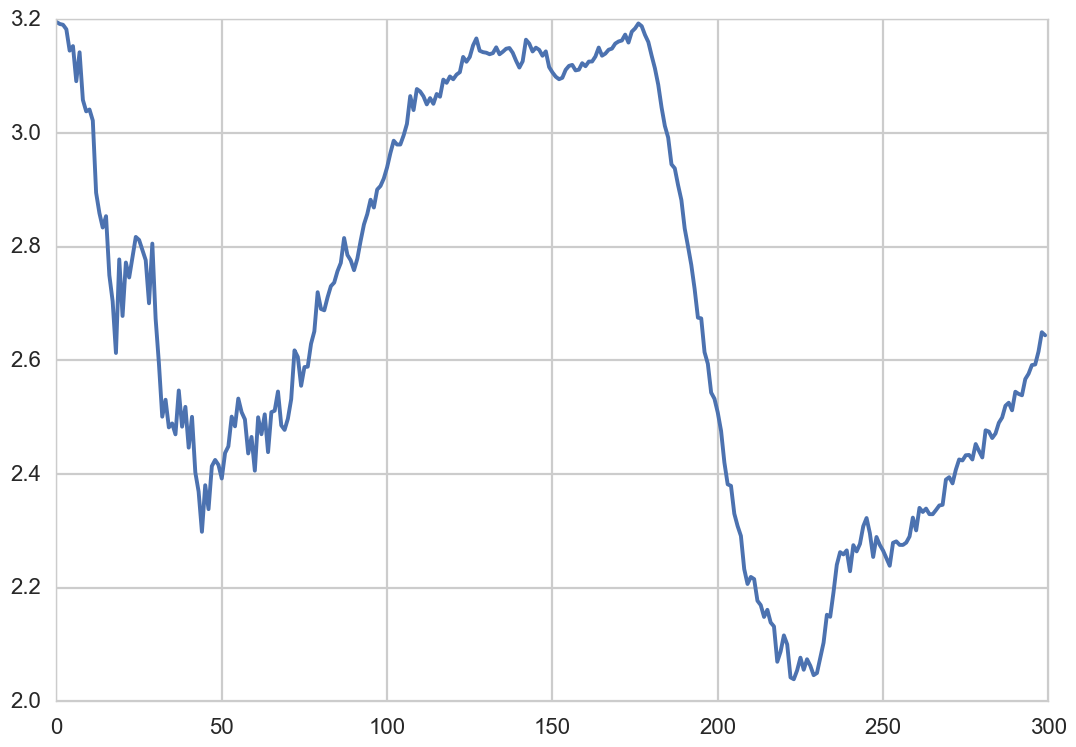

In [1107]:
result_params, lk = ExpectationMaximisation(ys, copy.deepcopy(params))
probs = calculate_prediction_probabilities(ys, result_params, np.array([1,0,0,0,0]))

plt.plot(probs)

In [ ]:
cp1, cp2, cp3 = 100,200,len(ys)

In [1136]:
result_params0, _ = ExpectationMaximisation(ys[:cp1], copy.deepcopy(params))
result_params1, _ = ExpectationMaximisation(ys[cp1:cp2], copy.deepcopy(params))
result_params2, _ = ExpectationMaximisation(ys[cp2:], copy.deepcopy(params))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

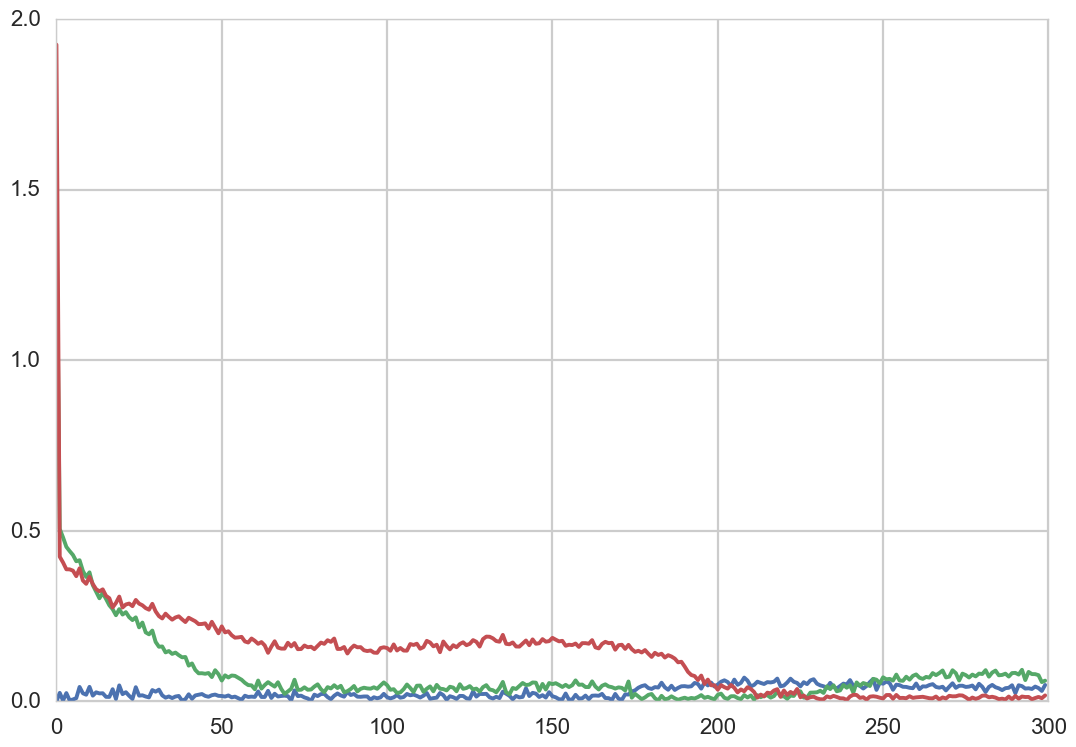

In [1137]:
fwd_params0 = ForwardKalmanFilter(
                    ys, result_params0['mu0'], result_params0['Sig0'],
                    result_params0['Phi'], result_params0['Q'], result_params0['R']
                )

fwd_params1 = ForwardKalmanFilter(
                    ys, result_params1['mu0'], result_params1['Sig0'],
                    result_params1['Phi'], result_params1['Q'], result_params1['R']
                )

fwd_params2 = ForwardKalmanFilter(
                    ys, result_params2['mu0'], result_params2['Sig0'],
                    result_params2['Phi'], result_params2['Q'], result_params2['R']
                )

plt.plot(np.sum(np.abs(fwd_params0['innovations']), axis=1))
plt.plot(np.sum(np.abs(fwd_params1['innovations']), axis=1))
plt.plot(np.sum(np.abs(fwd_params2['innovations']), axis=1))

errs = np.concatenate([
        np.sum(np.abs(fwd_params0['innovations']), axis=1).reshape(-1,1),
        np.sum(np.abs(fwd_params1['innovations']), axis=1).reshape(-1,1),
        np.sum(np.abs(fwd_params2['innovations']), axis=1).reshape(-1,1)
    ], axis=1)
np.argmin(errs, axis=1)
# plt.plot(fwd_params0['incomplete_likelihood'])
# plt.plot(fwd_params1['incomplete_likelihood'])

In [1151]:
cp1, cp2, cp3 = [np.max(np.where(np.argmin(errs, axis=1) == i)) for i in range(3)]
cp1, cp2, cp3

(173, 226, 299)

In [1149]:
T = len(ys)
num_breaks = 3
np.concatenate([np.arange(T//num_breaks, T, T//num_breaks), [T]])

array([100, 200, 300])

In [1416]:
def learn_breakpoint(ys, num_breaks, starting_params, percentage=98):
    
    T = len(ys)
    break_points = []
    
    # initialise the cut points
    breaks = np.concatenate([[0], np.arange(T//num_breaks, T, T//num_breaks)[:num_breaks-1], [T]])
    break_points.append(breaks)
    
    # iterate to find the new breaks
    for i in range(10):
        
        print(breaks)
        
        result_params, fwd_filts = [], []
        for j in range(1, len(breaks)):
            
            p_, _ = ExpectationMaximisation(ys[breaks[j-1]:breaks[j]], copy.deepcopy(params))
            result_params.append(p_)

            fwd_filt = ForwardKalmanFilter(
                        ys,
                        p_['mu0'],
                        p_['Sig0'],
                        p_['Phi'], 
                        p_['Q'],
                        p_['R']
                    )
            
            fwd_filts.append(fwd_filt)
            
        errs = np.concatenate([np.sum(np.abs(fwd['innovations']), axis=1).reshape(-1,1) for fwd in fwd_filts], axis=1)
    
        if num_breaks > 1:
            breaks = np.concatenate([[0], [int(np.percentile(np.where(np.argmin(errs, axis=1) == i), percentage)) for i in range(num_breaks)][:num_breaks-1], [T]])
        else:
            breaks = np.concatenate([[0],[T]])
            
        if len(np.where(np.diff(breaks) < 30)[0]) > 0:
            
            remove = np.where(np.diff(breaks) < 30)[0][-1]
            print(remove)
            breaks = list(breaks)
            del breaks[remove]
            num_breaks -= 1
            breaks = np.array(breaks, dtype=np.int64)
            
        elif np.sum(np.abs((breaks - break_points[i]))) <= num_breaks-1:
            break
        
        break_points.append(breaks)
        
    return {
        'result_params': result_params,
        'fwd_filts': fwd_filts,
        'breaks': breaks
    }

In [1417]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

learnt_params = learn_breakpoint(ys, 3, params, percentage=100)

[  0 100 200 300]
[  0 174 222 300]
[  0 173 226 300]


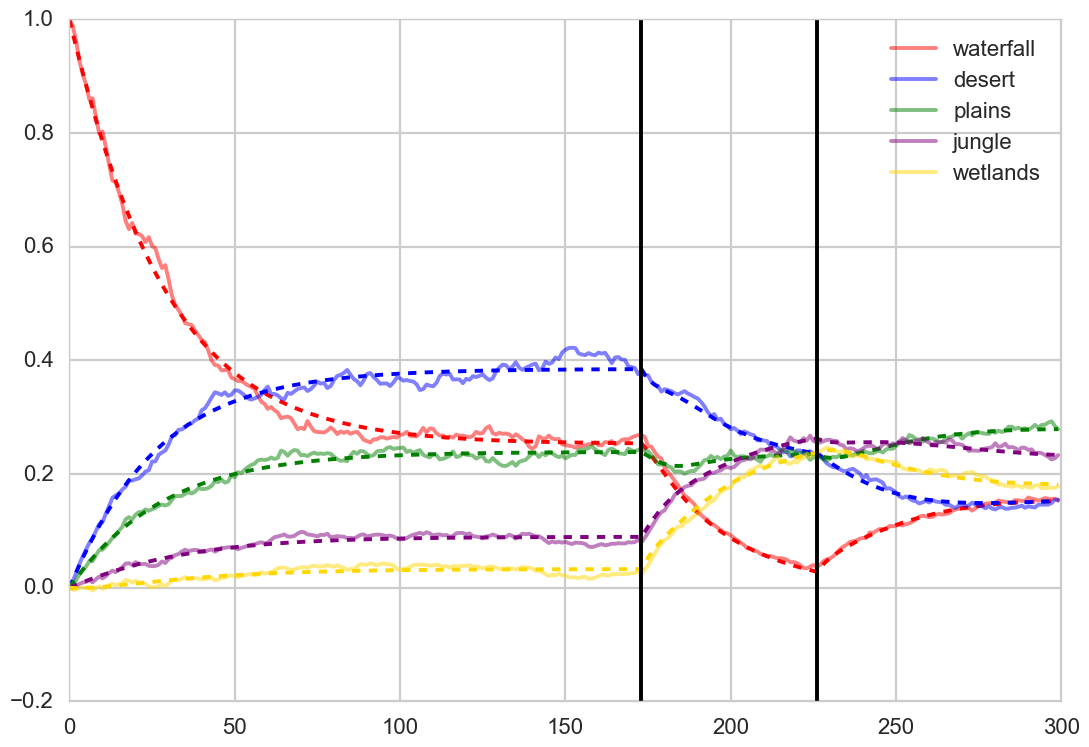

In [1418]:
times = learnt_params['breaks'][1:]
times[-1] = len(ys)
results = learnt_params['result_params']

water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = results[0]['Phi']

j = 1
for i in timesteps:
    
    if j <= len(times):
        if i > times[j-1]:
            
            Phi = results[j]['Phi']
            j += 1
           
    water.append(A.dot(Phi.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']

for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')
    ax.plot(water_sim[:,i], label=labels[i], c=c[i], alpha=0.5)

for j in times[:-1]:
    ax.axvline(j, c='black')
    
plt.legend(loc='best')
plt.show()

In [2031]:
arr = np.array([1,0,0,0,0])

In [2371]:
arr  = results[1]['Phi'].dot(arr)
arr

array([ 0.00777597,  0.22046798,  0.23851332,  0.27681928,  0.25641734])

In [2373]:
starting_arr = np.array([1,0,0,0,0])
for j in range(len(results)):
    
    for i in range(1000):
        
        starting_arr = results[j]['Phi'].dot(starting_arr)
        
    print()
    print(starting_arr)


[ 0.25297489  0.38521269  0.23921049  0.08975703  0.03289489]

[-0.00673108  0.20947037  0.24067685  0.28693917  0.26969749]

[ 0.14856044  0.16068518  0.27625805  0.22938179  0.18463822]


# Does this work at all on CW data?

In [2380]:
data_csvs = {}
data_csvs['df_1'] = pd.read_csv("./2017-09-19T10_01_14-0.csv").iloc[6:]
data_csvs['df_2'] = pd.read_csv("./log-0-Free_Play_for_research.csv").iloc[6:]
data_csvs['df_3'] = pd.read_csv("./0-ESSIL_October_Test-2017-11-16.csv").iloc[6:]
data_csvs['df_4'] = pd.read_csv("./2017-09-06T09_35_14-1.csv").iloc[6:]

for k,v in data_csvs.items():
    
    data_csvs[k].columns = data_csvs[k].columns.str.strip()
    data_csvs[k] = data_csvs[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs[k]['Other_Water'] = 2.5-data_csvs[k].sum(axis=1)
    data_csvs[k] = data_csvs[k] / 2.5
    data_csvs[k] = data_csvs[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]

data_csvs['df_2'].head(2)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,0.999982,0.0,0.000018,0.0,0.0
7,0.995726,0.0,0.004274,0.0,0.0


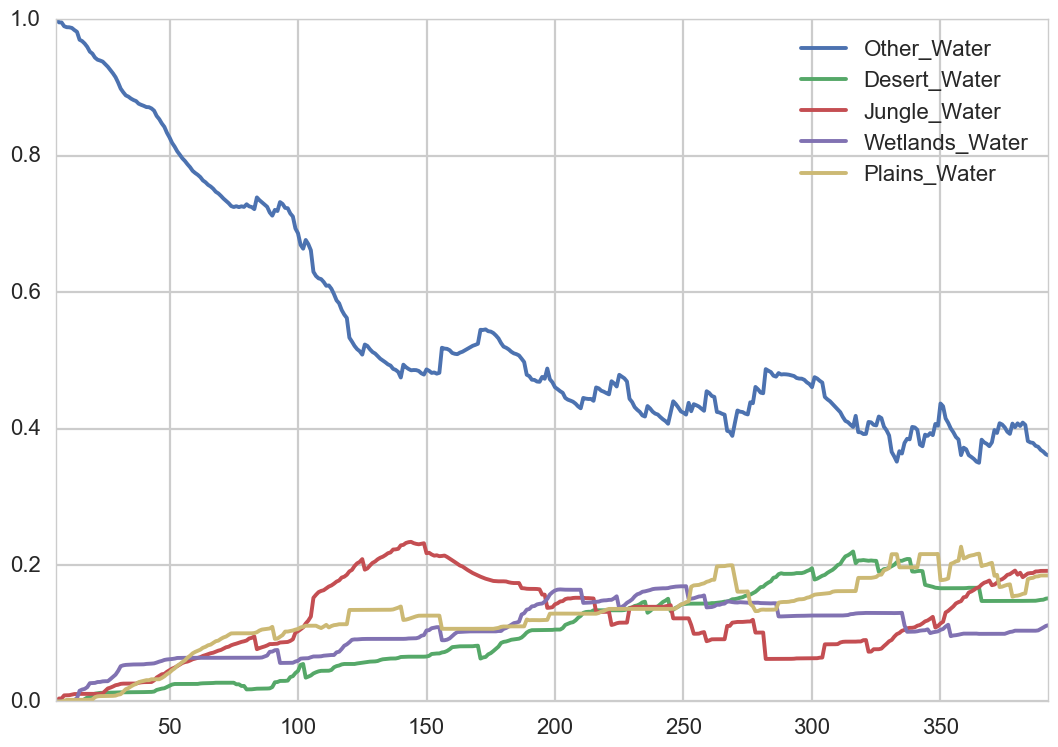

In [2381]:
df = 'df_2'
data_csvs[df].plot()

In [1409]:
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(5)
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

result_params, lk = ExpectationMaximisation(data_csvs[df].values, copy.deepcopy(params))
print(result_params['Phi'])

[[  9.94421506e-01   2.26521632e-03   2.51131185e-03   1.06767180e-02
   -1.80537833e-03]
 [  9.99205317e-05   9.91500855e-01  -6.09362426e-04   2.09063062e-02
   -6.92692761e-03]
 [  1.72556421e-03  -1.88410124e-02   9.87414155e-01  -2.46744232e-02
    4.40566458e-02]
 [  1.62573171e-03   8.55873561e-03   9.86673793e-03   9.89319472e-01
   -1.24756528e-02]
 [  2.12706149e-03   1.65164891e-02   8.17620859e-04   3.77280449e-03
    9.77150453e-01]]


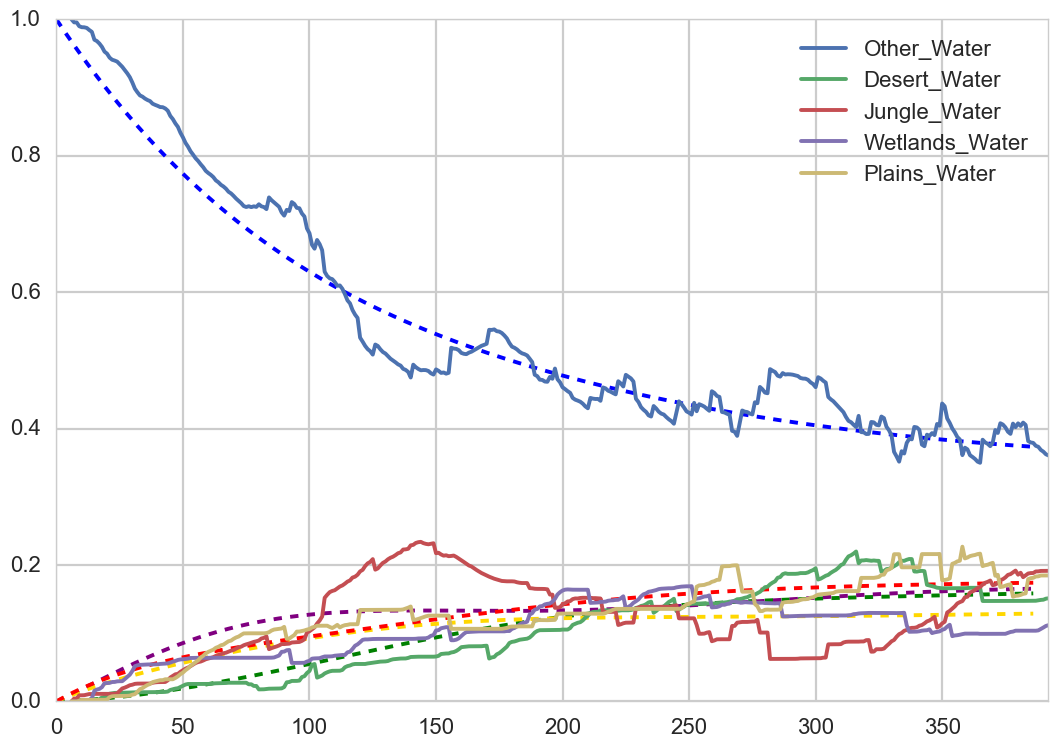

In [1410]:
water = [np.array([1,0,0,0,0])]

N = 5
T = len(data_csvs[df].values)
timesteps = np.arange(1,T )
A = np.eye(5)

Phi = result_params['Phi']

for i in timesteps:
    
    water.append(A.dot(Phi.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = [ 'b', 'g', 'purple', 'gold', 'r']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')

data_csvs[df].plot(ax=ax)
plt.show()

In [2374]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

learnt_params = learn_breakpoint(data_csvs[df].values, 4, params, percentage=90)

[  0  96 192 288 387]
[  0  89 187 297 387]
[  0  82 206 299 387]
[  0  85 196 297 387]
[  0  88 190 296 387]
[  0  82 198 298 387]
[  0  85 189 296 387]
[  0  88 190 297 387]
[  0  82 195 297 387]
[  0  86 190 296 387]


In [2375]:
times=[upr_idx0, upr_idx1, upr_idx]
results = [result_params, result_params, result_params]

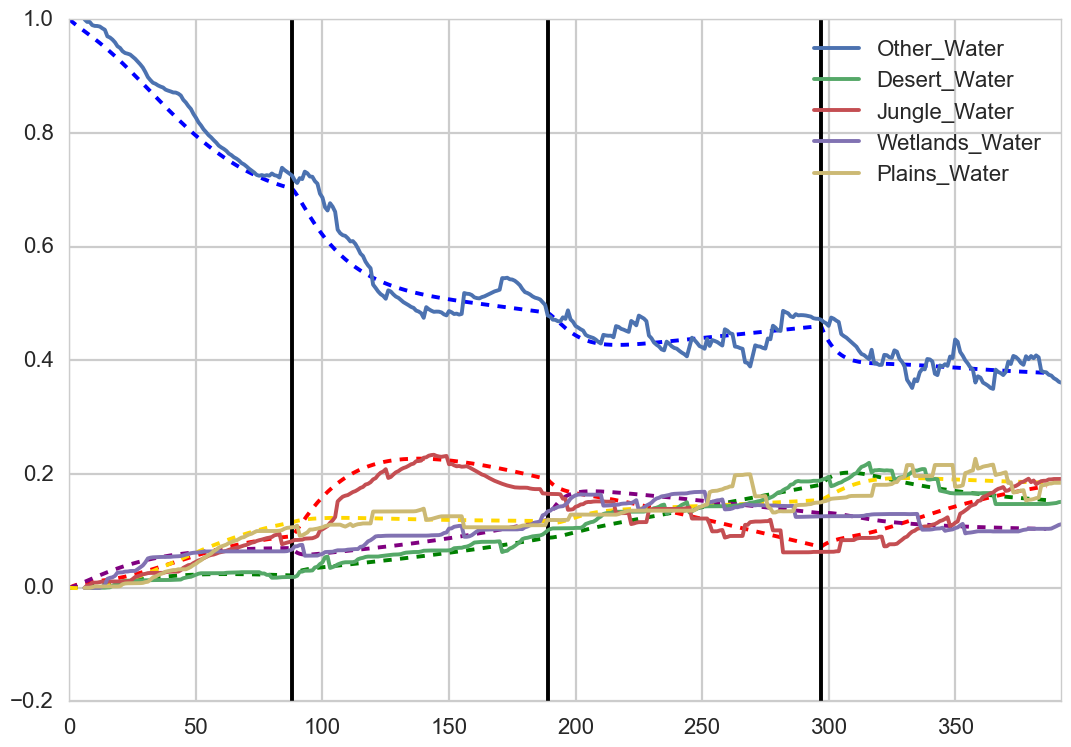

In [2376]:
times = learnt_params['breaks'][1:]
times[-1] = len(data_csvs[df].values)
results = learnt_params['result_params']

water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,len(data_csvs[df].values))
A = np.eye(5)

Phi = results[0]['Phi']

j = 1
for i in timesteps:
    
    if j <= len(times):
        if i > times[j-1]:
            
            Phi = results[j]['Phi']
            j += 1
           
    water.append(A.dot(Phi.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = ['b', 'g', 'r', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']

for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')

for j in times[:-1]:
    ax.axvline(j, c='black')
    
data_csvs[df].plot(ax=ax)
plt.show()

Here we can calculate some summary statistics that describe where the water has gone after each of the time breaks.

In [2379]:
starting_arr = np.array([1,0,0,0,0])
for j in range(len(results)):
    
    for i in range(learnt_params['breaks'][j+1] - learnt_params['breaks'][j]):
        
        starting_arr = results[j]['Phi'].dot(starting_arr)
        
    print()
    print(starting_arr)


[ 0.70237021  0.02179211  0.09074165  0.06991229  0.11494669]

[ 0.4840483   0.08818773  0.1906953   0.11933373  0.11748184]

[ 0.46064517  0.18142737  0.07201099  0.1313345   0.15431179]

[ 0.37798762  0.15395751  0.17939795  0.10339281  0.18500999]


### 2017-11-16 ESSIL Test

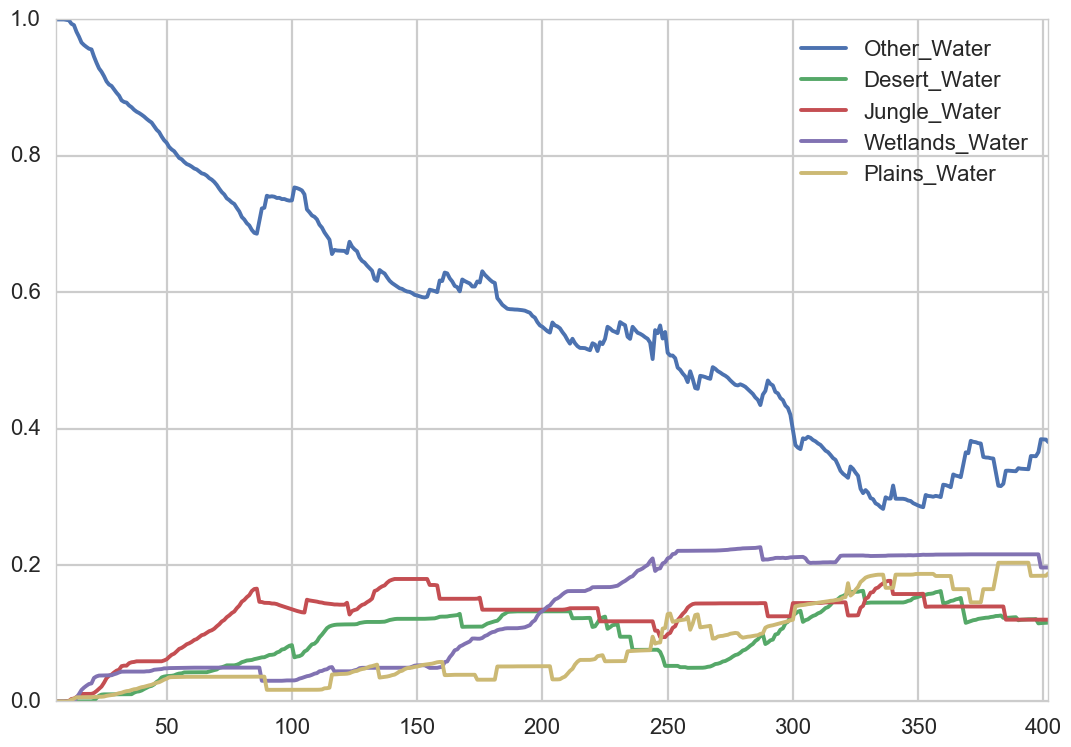

In [2383]:
df = 'df_3'
data_csvs[df].plot()

In [2384]:
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(5)
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

result_params, lk = ExpectationMaximisation(data_csvs[df].values, copy.deepcopy(params))
print(result_params['Phi'])

[[  9.94885017e-01  -1.14934776e-02   2.26965844e-02  -1.93360100e-02
    2.57010074e-02]
 [  1.49441767e-04   9.78808180e-01   1.85577318e-02  -4.26745389e-03
    5.30393354e-03]
 [  2.61597828e-03  -6.11690414e-03   9.91667035e-01  -2.12854325e-03
    8.82820006e-03]
 [  1.55574067e-03   2.02487478e-02  -1.64035206e-02   1.00898735e+00
   -1.72836131e-02]
 [  7.93609950e-04   1.85507539e-02  -1.65156234e-02   1.67449946e-02
    9.77450686e-01]]


In [2390]:
data_csvs[df].head()

,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,1.000000,0.0,0.000000,0.0,0.0
7,1.000000,0.0,0.000000,0.0,0.0
8,1.000000,0.0,0.000000,0.0,0.0
9,0.999982,0.0,0.000018,0.0,0.0
10,0.999373,0.0,0.000627,0.0,0.0


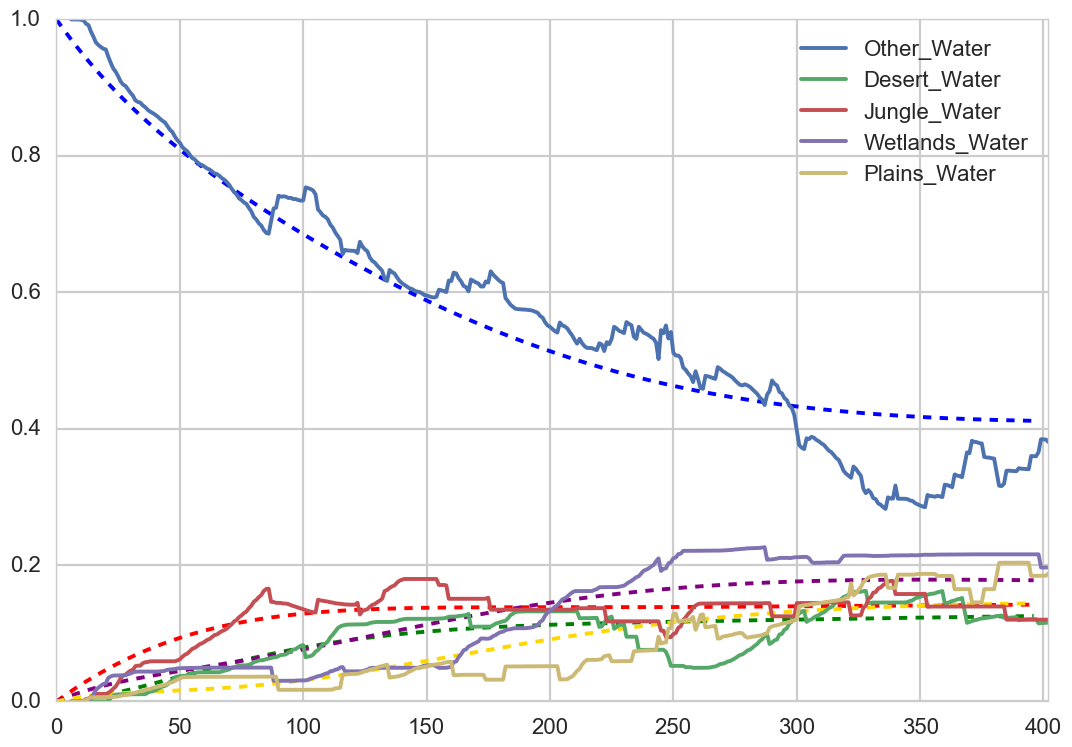

In [2393]:
water = [np.array([1,0,0,0,0])]

N = 5
T = len(data_csvs[df].values)
timesteps = np.arange(1,T )
A = np.eye(5)

Phi = result_params['Phi']

for i in timesteps:
    
    water.append(A.dot(Phi.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = ['b', 'g', 'r', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')

data_csvs[df].plot(ax=ax)
plt.show()

In [2394]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

learnt_params = learn_breakpoint(data_csvs[df].values, 4, params, percentage=90)

[  0  99 198 297 397]
[  0  95 202 285 397]
[  0  99 197 273 397]
[  0  94 205 264 397]
[  0 106 201 257 397]
[  0 129 202 250 397]
[  0 147 203 241 397]
[  0 146 201 235 397]
[  0 146 201 231 397]
2
[  0 146 228 397]


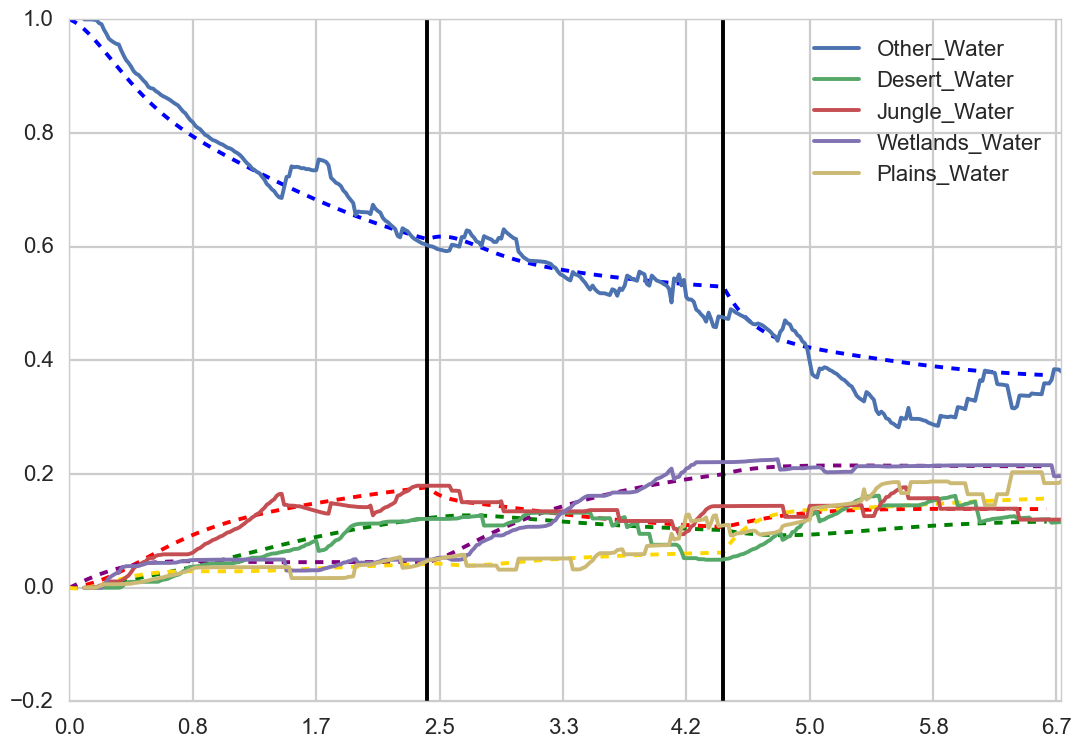

In [2420]:
times = learnt_params['breaks'][1:]
times[-1] = len(data_csvs[df].values)
results = learnt_params['result_params']

water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,len(data_csvs[df].values))
A = np.eye(5)

Phi = results[0]['Phi']

j = 1
for i in timesteps:
    
    if j <= len(times):
        if i > times[j-1]:
            
            Phi = results[j]['Phi']
            j += 1
           
    water.append(A.dot(Phi.dot(water[i-1])))
    
water = np.array(water)

fig, ax = plt.subplots(1,1)

c = ['b', 'g', 'r', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']

for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')

for j in times[:-1]:
    ax.axvline(j, c='black')
    
data_csvs[df].plot(ax=ax)
ax.set_xticklabels([round(i/60,1) for i in ax.get_xticks()])

plt.show()

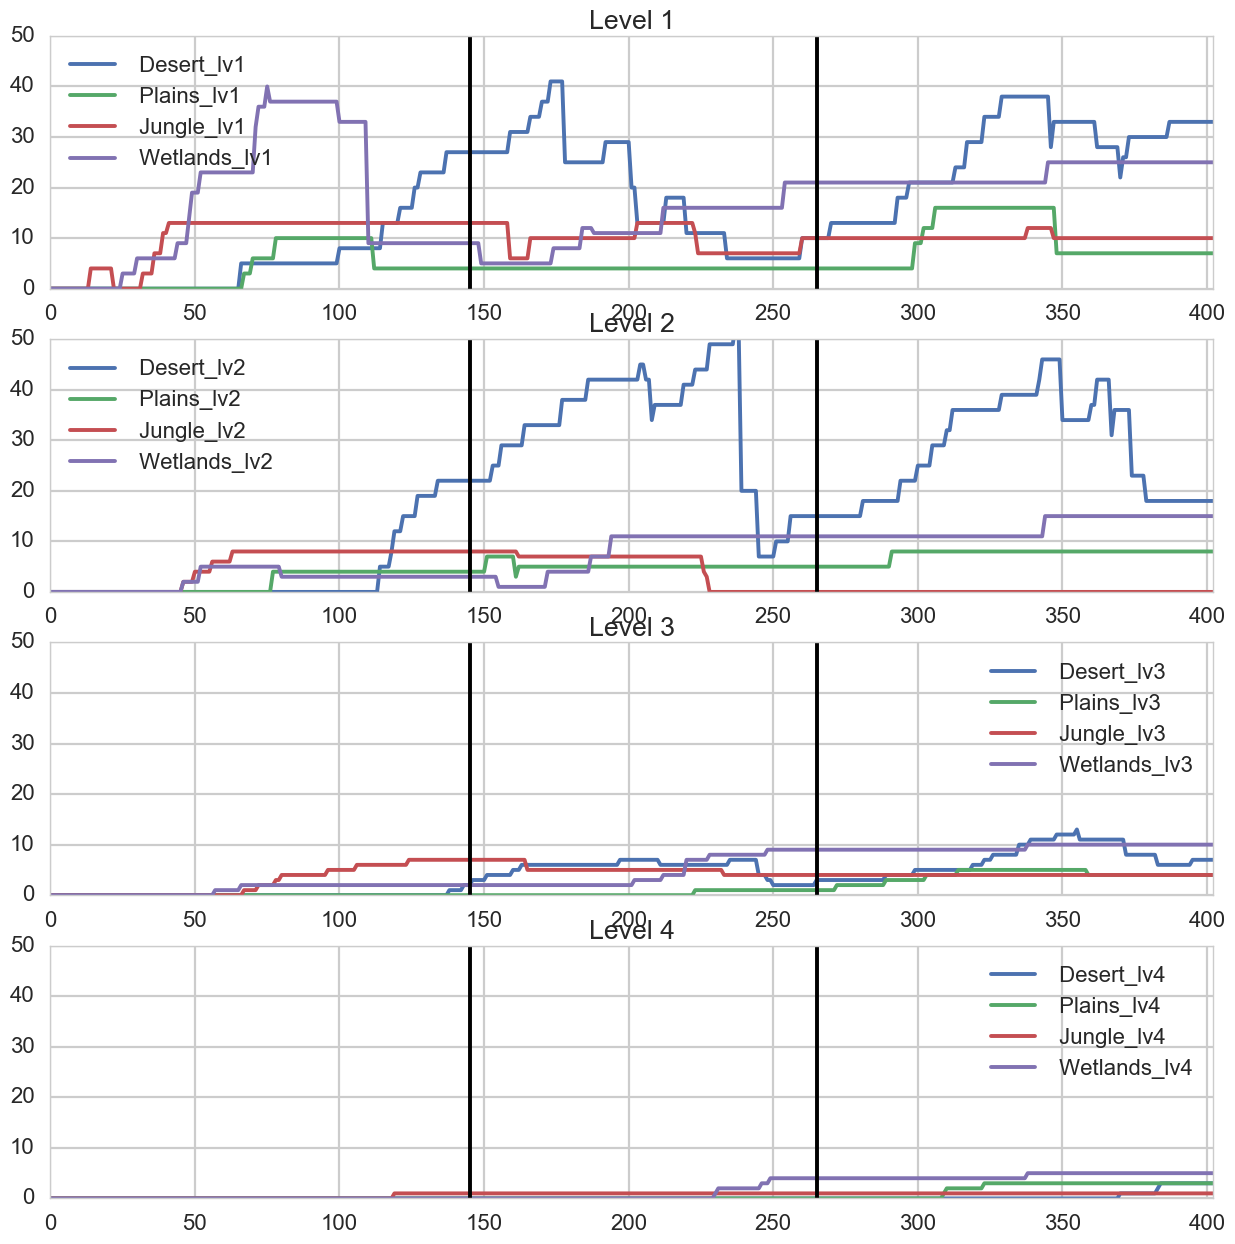

In [2400]:
data = pd.read_csv("./0-ESSIL_October_Test-2017-11-16.csv")
plants_subset = data[data.columns[data.columns.str.contains('lv') & (~data.columns.str.contains('Dead'))]]

fig, axes = plt.subplots(4,1, figsize=(15,15))
axes = axes.flatten()

plants_subset[plants_subset.columns[plants_subset.columns.str.contains('lv1')]].plot(ax=axes[0])
axes[0].set_title('Level 1')

plants_subset[plants_subset.columns[plants_subset.columns.str.contains('lv2')]].plot(ax=axes[1])
axes[1].set_title('Level 2')

plants_subset[plants_subset.columns[plants_subset.columns.str.contains('lv3')]].plot(ax=axes[2])
axes[2].set_title('Level 3')

plants_subset[plants_subset.columns[plants_subset.columns.str.contains('lv4')]].plot(ax=axes[3])
axes[3].set_title('Level 4')

for ax in axes:
    ax.set_ylim([0,50])
    for j in times[:-1]:
        ax.axvline(j, c='black')

plt.show()